# Análisis de Clustering en Datos Raw de DeepSolation

Este notebook carga todos los datos raw de señales sin preprocesar y aplica algoritmos de clustering para analizar la distribución natural de los datos y evaluar si hay separación entre diferentes niveles de daño.

## Objetivos:
1. Cargar todos los datos raw desde `data/Signals_Raw/`
2. Crear dataset con etiquetas correspondientes
3. Aplicar K-means clustering (k=3) para análisis exploratorio
4. Visualizar resultados y evaluar separabilidad

In [6]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Importar función utilitaria directamente del archivo
import importlib.util
spec = importlib.util.spec_from_file_location("dataset_utils", "../src/utils/dataset_utils.py")
dataset_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dataset_utils)

# Obtener la función
load_raw_signals_dataset = dataset_utils.load_raw_signals_dataset

# Configuración de plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("📦 Librerías cargadas correctamente")

📦 Librerías cargadas correctamente


## 1. Carga de Datos Raw

Utilizamos la función utilitaria para cargar todos los archivos de señales y crear el dataset completo.

In [7]:
# Rutas de datos
SIGNALS_DIR = "../data/Signals_Raw/"
LABELS_CSV = "../data/nivel_damage.csv"

# Verificar que las rutas existen
if not os.path.exists(SIGNALS_DIR):
    raise FileNotFoundError(f"Directorio no encontrado: {SIGNALS_DIR}")
if not os.path.exists(LABELS_CSV):
    raise FileNotFoundError(f"Archivo no encontrado: {LABELS_CSV}")

print(f"✓ Directorio de señales: {SIGNALS_DIR}")
print(f"✓ Archivo de etiquetas: {LABELS_CSV}")

✓ Directorio de señales: ../data/Signals_Raw/
✓ Archivo de etiquetas: ../data/nivel_damage.csv


In [8]:
# Cargar dataset completo
print("🔄 Cargando datos raw...\n")
raw_dataset = load_raw_signals_dataset(SIGNALS_DIR, LABELS_CSV)

# Mostrar información básica
print(f"\n📊 Dataset cargado:")
print(f"Shape: {raw_dataset.shape}")
print(f"Columnas: {list(raw_dataset.columns)}")
print(f"Memoria: {raw_dataset.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

🔄 Cargando datos raw...

✓ Cargadas etiquetas para 34 especímenes
✓ Encontradas 34 carpetas de especímenes
✓ A1 S1: 60001 muestras
✓ A1 S2: 60001 muestras
✓ A1-2 S1: 60001 muestras
✓ A1-2 S2: 60001 muestras
✓ A1-3 S1: 72000 muestras
✓ A1-3 S2: 72000 muestras
✓ A10 S1: 60001 muestras
✓ A10 S2: 60001 muestras
✓ A10-2 S1: 60001 muestras
✓ A10-2 S2: 60001 muestras
✓ A10-3 S1: 60000 muestras
✓ A10-3 S2: 60000 muestras
✓ A11 S1: 60001 muestras
✓ A11 S2: 60001 muestras
✓ A11-2 S1: 60001 muestras
✓ A11-2 S2: 60001 muestras
✓ A11-3 S1: 60001 muestras
✓ A11-3 S2: 60001 muestras
✓ A12 S1: 60001 muestras
✓ A12 S2: 60001 muestras
✓ A13 S1: 60001 muestras
✓ A13 S2: 60001 muestras
✓ A14 S1: 60001 muestras
✓ A14 S2: 60001 muestras
✓ A2 S1: 60001 muestras
✓ A2 S2: 60001 muestras
✓ A2-2 S1: 60001 muestras
✓ A2-2 S2: 60001 muestras
✓ A2-3 S1: 60001 muestras
✓ A2-3 S2: 60001 muestras
✓ A3 S1: 58700 muestras
✓ A3 S2: 58700 muestras
✓ A3-2 S1: 60001 muestras
✓ A3-2 S2: 60001 muestras
✓ A3-3 S1: 60001 muestr

In [9]:
# Explorar estructura del dataset
print("🔍 Exploración inicial:")
print("\nPrimeras 5 filas:")
display(raw_dataset.head())

print("\nInformación del dataset:")
display(raw_dataset.info())

print("\nEstadísticas descriptivas:")
display(raw_dataset[['N_S', 'E_W', 'U_D']].describe())

🔍 Exploración inicial:

Primeras 5 filas:


,ID,sensor,timestamp,N_S,E_W,U_D,tipo,nivel_damage
0,A1,S1,2024-05-23 09:47:00.000,0.031831,-0.037262,-0.030082,B,N1
1,A1,S1,2024-05-23 09:47:00.010,0.050754,-0.017640,0.009745,B,N1
2,A1,S1,2024-05-23 09:47:00.020,0.016400,-0.024883,0.001562,B,N1
3,A1,S1,2024-05-23 09:47:00.030,0.000805,-0.018291,0.008129,B,N1
4,A1,S1,2024-05-23 09:47:00.040,0.020492,0.042602,0.000423,B,N1



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4185254 entries, 0 to 4185253
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   ID            object        
 1   sensor        object        
 2   timestamp     datetime64[ns]
 3   N_S           float64       
 4   E_W           float64       
 5   U_D           float64       
 6   tipo          object        
 7   nivel_damage  object        
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 255.4+ MB


None


Estadísticas descriptivas:


,N_S,E_W,U_D
count,4.185254e+06,4.185254e+06,4.185254e+06
mean,1.379148e-03,2.868750e-04,4.507304e-05
std,4.225059e-01,2.622928e-01,2.106519e-01
min,-1.322224e+01,-1.579552e+01,-1.720450e+01
25%,-3.243436e-02,-3.331321e-02,-1.626215e-02
50%,-3.692044e-04,0.000000e+00,-1.304563e-04
75%,3.114926e-02,3.153217e-02,1.600710e-02
max,3.044715e+01,2.387484e+01,2.107681e+01


## 2. Análisis Exploratorio

Antes del clustering, exploramos la distribución de los datos y características por nivel de daño.

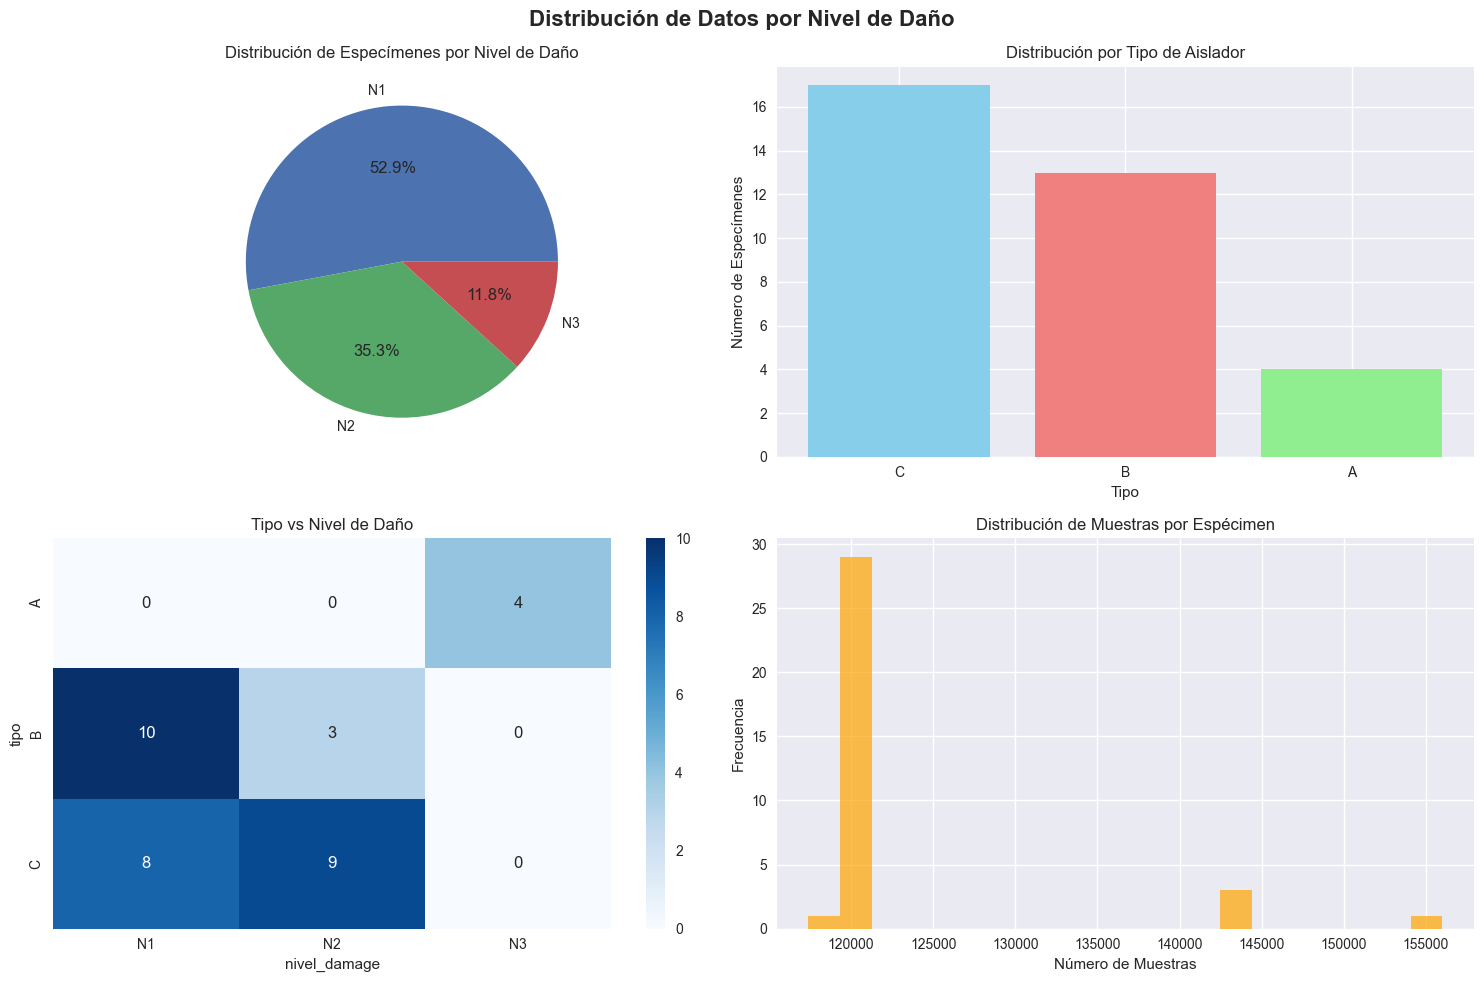


📈 Estadísticas clave:
Total especímenes únicos: 34
Total muestras: 4,185,254
Muestras promedio por espécimen: 123096
Sensores: ['S1', 'S2']


In [10]:
# Distribución por nivel de daño
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribución de Datos por Nivel de Daño', fontsize=16, fontweight='bold')

# Conteos por nivel
damage_counts = raw_dataset.groupby('ID')['nivel_damage'].first().value_counts()
axes[0,0].pie(damage_counts.values, labels=damage_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Distribución de Especímenes por Nivel de Daño')

# Conteos por tipo
type_counts = raw_dataset.groupby('ID')['tipo'].first().value_counts()
axes[0,1].bar(type_counts.index, type_counts.values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0,1].set_title('Distribución por Tipo de Aislador')
axes[0,1].set_xlabel('Tipo')
axes[0,1].set_ylabel('Número de Especímenes')

# Matriz de correlación tipo vs nivel
cross_tab = pd.crosstab(raw_dataset.groupby('ID')['tipo'].first(), 
                       raw_dataset.groupby('ID')['nivel_damage'].first())
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title('Tipo vs Nivel de Daño')

# Número de muestras por espécimen
samples_per_specimen = raw_dataset.groupby('ID').size()
axes[1,1].hist(samples_per_specimen.values, bins=20, alpha=0.7, color='orange')
axes[1,1].set_title('Distribución de Muestras por Espécimen')
axes[1,1].set_xlabel('Número de Muestras')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f"\n📈 Estadísticas clave:")
print(f"Total especímenes únicos: {raw_dataset['ID'].nunique()}")
print(f"Total muestras: {len(raw_dataset):,}")
print(f"Muestras promedio por espécimen: {len(raw_dataset) / raw_dataset['ID'].nunique():.0f}")
print(f"Sensores: {sorted(raw_dataset['sensor'].unique())}")

## 3. Preparación de Datos para Clustering

Preparamos los datos para clustering agregando características estadísticas por espécimen y sensor.

In [11]:
# Calcular características estadísticas por espécimen y sensor
print("🔧 Calculando características estadísticas...")

def calculate_signal_features(group):
    """Calcula características estadísticas para un grupo de señales"""
    features = {}
    
    for axis in ['N_S', 'E_W', 'U_D']:
        signal = group[axis]
        
        # Estadísticas básicas
        features[f'{axis}_mean'] = signal.mean()
        features[f'{axis}_std'] = signal.std()
        features[f'{axis}_min'] = signal.min()
        features[f'{axis}_max'] = signal.max()
        features[f'{axis}_range'] = signal.max() - signal.min()
        
        # Estadísticas de forma
        features[f'{axis}_skew'] = signal.skew()
        features[f'{axis}_kurtosis'] = signal.kurtosis()
        
        # Energía (RMS)
        features[f'{axis}_rms'] = np.sqrt(np.mean(signal**2))
        
        # Percentiles
        features[f'{axis}_q25'] = signal.quantile(0.25)
        features[f'{axis}_q75'] = signal.quantile(0.75)
    
    # Características combinadas
    features['magnitude_mean'] = np.sqrt(group['N_S']**2 + group['E_W']**2 + group['U_D']**2).mean()
    features['magnitude_std'] = np.sqrt(group['N_S']**2 + group['E_W']**2 + group['U_D']**2).std()
    
    return pd.Series(features)

# Aplicar cálculo de características por espécimen y sensor
features_df = raw_dataset.groupby(['ID', 'sensor']).apply(calculate_signal_features).reset_index()

# Agregar metadatos
metadata = raw_dataset.groupby(['ID', 'sensor'])[['tipo', 'nivel_damage']].first().reset_index()
features_df = features_df.merge(metadata, on=['ID', 'sensor'])

print(f"✓ Características calculadas:")
print(f"  Shape: {features_df.shape}")
print(f"  Características por sensor: {features_df.shape[1]-4}")
print(f"  Total observaciones: {len(features_df)}")

🔧 Calculando características estadísticas...
✓ Características calculadas:
  Shape: (68, 36)
  Características por sensor: 32
  Total observaciones: 68


In [12]:
# Ver algunas características calculadas
print("🔍 Primeras características calculadas:")
display(features_df.head())

print("\n📊 Estadísticas de características:")
feature_cols = [col for col in features_df.columns if col not in ['ID', 'sensor', 'tipo', 'nivel_damage']]
display(features_df[feature_cols].describe())

🔍 Primeras características calculadas:


,ID,sensor,N_S_mean,N_S_std,N_S_min,N_S_max,N_S_range,N_S_skew,N_S_kurtosis,N_S_rms,...,U_D_range,U_D_skew,U_D_kurtosis,U_D_rms,U_D_q25,U_D_q75,magnitude_mean,magnitude_std,tipo,nivel_damage
0,A1,S1,-0.000026,0.031216,-0.243628,0.212175,0.455803,0.000757,1.326245,0.031216,...,0.458026,0.006942,0.991691,0.037451,-0.023732,0.023696,0.058878,0.030169,B,N1
1,A1,S2,0.000006,0.054210,-0.886049,1.150439,2.036488,0.081651,6.900296,0.054210,...,0.365678,0.017157,0.848136,0.025589,-0.016042,0.016685,0.089217,0.053750,B,N1
2,A1-2,S1,-0.000033,0.028741,-0.140330,0.158671,0.299002,0.018875,0.717615,0.028741,...,0.367711,-0.240082,1.919972,0.020198,-0.012110,0.011872,0.068129,0.052275,B,N1
3,A1-2,S2,-0.000560,0.074277,-0.988721,0.772165,1.760885,-0.098471,3.551313,0.074278,...,2.714994,0.131129,7.413277,0.105980,-0.060588,0.061073,0.137522,0.080721,B,N1
4,A1-3,S1,0.000003,0.024576,-0.139409,0.153669,0.293079,-0.008731,0.666451,0.024576,...,0.243566,0.039679,0.840599,0.016027,-0.010391,0.010090,0.050605,0.030177,B,N1



📊 Estadísticas de características:


,N_S_mean,N_S_std,N_S_min,N_S_max,N_S_range,N_S_skew,N_S_kurtosis,N_S_rms,N_S_q25,N_S_q75,...,U_D_min,U_D_max,U_D_range,U_D_skew,U_D_kurtosis,U_D_rms,U_D_q25,U_D_q75,magnitude_mean,magnitude_std
count,6.800000e+01,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,9.075032e-04,0.118936,-0.898432,1.259215,2.157647,0.110909,15.728768,0.119366,-0.050050,0.033980,...,-0.640674,0.805644,1.446318,0.958637,146.991736,0.059534,-0.020265,0.020035,0.106829,0.119242
std,1.539333e-02,0.413442,1.803391,4.013733,5.583736,0.804750,77.732967,0.413600,0.095384,0.078671,...,2.073758,2.634440,4.662116,7.507702,1149.469071,0.206317,0.013324,0.013476,0.166016,0.499681
min,-5.176716e-02,0.015615,-13.222240,0.102094,0.214356,-0.260876,-0.920987,0.015615,-0.802155,-0.523715,...,-17.204500,0.057322,0.133981,-0.311487,0.368343,0.011501,-0.069817,0.001709,0.026109,0.016425
25%,-1.714618e-05,0.032647,-0.776410,0.315278,0.628882,-0.013220,1.126261,0.032647,-0.051286,0.018710,...,-0.467160,0.170134,0.359761,-0.014115,0.847320,0.019146,-0.022904,0.011431,0.049922,0.029440
50%,1.233895e-09,0.057378,-0.501006,0.520993,1.021224,-0.000695,2.291699,0.057378,-0.032698,0.031699,...,-0.230323,0.238973,0.494113,0.014212,2.527532,0.028596,-0.016063,0.016183,0.080603,0.052710
75%,1.478182e-05,0.087335,-0.309113,0.751003,1.452426,0.011120,6.761224,0.087334,-0.018809,0.050662,...,-0.174853,0.615360,1.091307,0.034972,7.463624,0.040185,-0.011453,0.023608,0.112202,0.077882
max,1.151015e-01,3.456692,-0.112262,30.447150,38.289377,6.542283,638.933434,3.457050,-0.010044,0.293155,...,-0.068718,21.076810,38.281310,61.900290,9485.489732,1.724139,-0.007318,0.069722,1.403568,4.167982


## 2.5. Visualización 3D de Señales Raw

Antes del clustering, visualizamos las señales raw en el espacio 3D (N-S, E-W, U-D) para observar la distribución espacial de los datos por nivel de daño.

🔍 Preparando visualización 3D de señales...


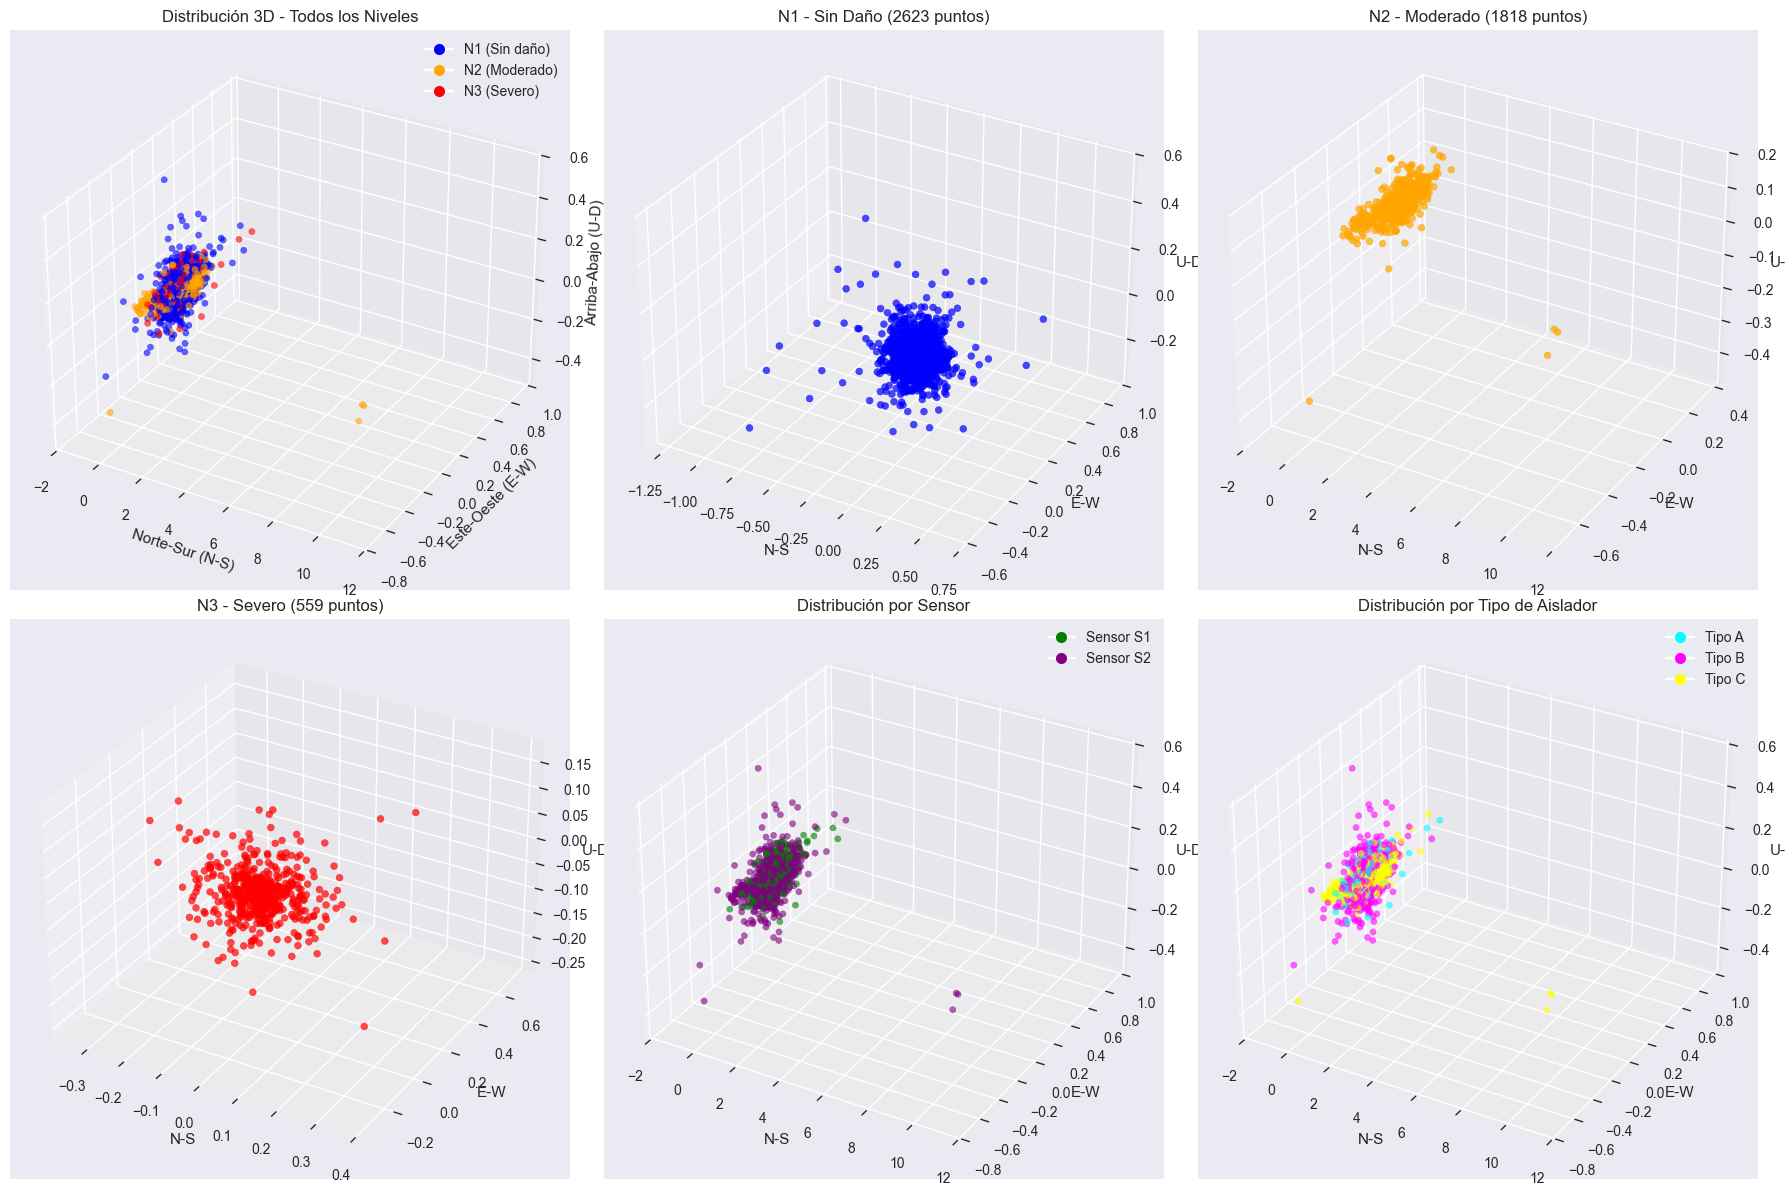

✓ Visualización 3D completada con 5000 puntos de muestra
  Distribución por nivel de daño:
    N1: 2623 puntos (52.5%)
    N2: 1818 puntos (36.4%)
    N3: 559 puntos (11.2%)


In [21]:
# Visualización 3D de las señales raw
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

print("🔍 Preparando visualización 3D de señales...")

# Tomar una muestra de datos para visualización (para evitar sobrecarga)
sample_size = min(5000, len(raw_dataset))  # Máximo 5000 puntos
sample_data = raw_dataset.sample(n=sample_size, random_state=42)

# Preparar colores por nivel de daño
damage_colors_map = {'N1': 'blue', 'N2': 'orange', 'N3': 'red'}
colors = [damage_colors_map[level] for level in sample_data['nivel_damage']]

# Crear figura con subplots 3D
fig = plt.figure(figsize=(18, 12))

# 1. Vista general con todos los niveles de daño
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
scatter = ax1.scatter(sample_data['N_S'], sample_data['E_W'], sample_data['U_D'], 
                     c=colors, alpha=0.6, s=20)
ax1.set_xlabel('Norte-Sur (N-S)')
ax1.set_ylabel('Este-Oeste (E-W)')
ax1.set_zlabel('Arriba-Abajo (U-D)')
ax1.set_title('Distribución 3D - Todos los Niveles')

# Crear leyenda manual
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='N1 (Sin daño)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='N2 (Moderado)'),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='N3 (Severo)')]
ax1.legend(handles=legend_elements, loc='upper right')

# 2-4. Vistas separadas por nivel de daño
damage_levels = ['N1', 'N2', 'N3']
damage_names = ['Sin Daño', 'Moderado', 'Severo']
positions = [(2, 3, 2), (2, 3, 3), (2, 3, 4)]

for i, (level, name, pos) in enumerate(zip(damage_levels, damage_names, positions)):
    ax = fig.add_subplot(*pos, projection='3d')
    level_data = sample_data[sample_data['nivel_damage'] == level]
    
    if not level_data.empty:
        ax.scatter(level_data['N_S'], level_data['E_W'], level_data['U_D'], 
                  c=damage_colors_map[level], alpha=0.7, s=25)
        ax.set_xlabel('N-S')
        ax.set_ylabel('E-W')
        ax.set_zlabel('U-D')
        ax.set_title(f'{level} - {name} ({len(level_data)} puntos)')
    else:
        ax.text(0.5, 0.5, 0.5, f'Sin datos para {level}', transform=ax.transAxes)

# 5. Vista por sensor
ax5 = fig.add_subplot(2, 3, 5, projection='3d')
sensor_colors_map = {'S1': 'green', 'S2': 'purple'}
sensor_colors = [sensor_colors_map[sensor] for sensor in sample_data['sensor']]

ax5.scatter(sample_data['N_S'], sample_data['E_W'], sample_data['U_D'], 
           c=sensor_colors, alpha=0.6, s=20)
ax5.set_xlabel('N-S')
ax5.set_ylabel('E-W')
ax5.set_zlabel('U-D')
ax5.set_title('Distribución por Sensor')

# Leyenda para sensores
sensor_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Sensor S1'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Sensor S2')]
ax5.legend(handles=sensor_legend, loc='upper right')

# 6. Vista por tipo de aislador
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
type_colors_map = {'A': 'cyan', 'B': 'magenta', 'C': 'yellow'}
type_colors = [type_colors_map[tipo] for tipo in sample_data['tipo']]

ax6.scatter(sample_data['N_S'], sample_data['E_W'], sample_data['U_D'], 
           c=type_colors, alpha=0.6, s=20)
ax6.set_xlabel('N-S')
ax6.set_ylabel('E-W')
ax6.set_zlabel('U-D')
ax6.set_title('Distribución por Tipo de Aislador')

# Leyenda para tipos
type_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=8, label='Tipo A'),
              Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=8, label='Tipo B'),
              Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Tipo C')]
ax6.legend(handles=type_legend, loc='upper right')

plt.tight_layout()
plt.show()

print(f"✓ Visualización 3D completada con {sample_size} puntos de muestra")
print(f"  Distribución por nivel de daño:")
for level in damage_levels:
    count = len(sample_data[sample_data['nivel_damage'] == level])
    print(f"    {level}: {count} puntos ({count/sample_size*100:.1f}%)")

## 4. Aplicación de K-means Clustering

Aplicamos K-means clustering con k=3 para ver si los datos se agrupan naturalmente según los niveles de daño.

In [13]:
# Preparar datos para clustering
print("🔧 Preparando datos para clustering...")

# Seleccionar solo características numéricas
X = features_df[feature_cols].copy()

# Verificar y manejar valores nulos/infinitos
print(f"Valores nulos: {X.isnull().sum().sum()}")
print(f"Valores infinitos: {np.isinf(X.values).sum()}")

# Reemplazar infinitos y nulos
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✓ Datos preparados:")
print(f"  Shape: {X_scaled.shape}")
print(f"  Sin valores nulos/infinitos")

# Aplicar K-means con k=3
print("\n🔄 Aplicando K-means clustering (k=3)...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Agregar etiquetas de cluster al dataframe
features_df['cluster'] = cluster_labels

print(f"✓ Clustering completado")
print(f"  Inercia: {kmeans.inertia_:.2f}")
print(f"  Silhouette score: {silhouette_score(X_scaled, cluster_labels):.3f}")

🔧 Preparando datos para clustering...
Valores nulos: 0
Valores infinitos: 0
✓ Datos preparados:
  Shape: (68, 32)
  Sin valores nulos/infinitos

🔄 Aplicando K-means clustering (k=3)...
✓ Clustering completado
  Inercia: 557.12
  Silhouette score: 0.822


In [14]:
# Analizar resultados de clustering
print("📊 Análisis de Clusters:")

# Distribución de clusters
cluster_dist = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nDistribución de clusters:")
for cluster, count in cluster_dist.items():
    print(f"  Cluster {cluster}: {count} observaciones ({count/len(cluster_labels)*100:.1f}%)")

# Comparar clusters vs etiquetas reales
print(f"\n🎯 Comparación Clusters vs Niveles de Daño:")
comparison_table = pd.crosstab(features_df['cluster'], features_df['nivel_damage'], margins=True)
display(comparison_table)

# Calcular Adjusted Rand Index
# Mapear niveles de daño a números para la comparación
damage_mapping = {'N1': 0, 'N2': 1, 'N3': 2}
true_labels = features_df['nivel_damage'].map(damage_mapping)
ari_score = adjusted_rand_score(true_labels, cluster_labels)

print(f"\n📈 Métricas de Evaluación:")
print(f"  Adjusted Rand Index: {ari_score:.3f}")
print(f"  Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

📊 Análisis de Clusters:

Distribución de clusters:
  Cluster 0: 66 observaciones (97.1%)
  Cluster 1: 1 observaciones (1.5%)
  Cluster 2: 1 observaciones (1.5%)

🎯 Comparación Clusters vs Niveles de Daño:


nivel_damage,N1,N2,N3,All
cluster,,,,
0,35,23,8,66
1,0,1,0,1
2,1,0,0,1
All,36,24,8,68



📈 Métricas de Evaluación:
  Adjusted Rand Index: -0.005
  Silhouette Score: 0.822


## 5. Visualización de Resultados

Visualizamos los resultados del clustering usando PCA y t-SNE para reducción de dimensionalidad.

In [15]:
# Reducción de dimensionalidad para visualización
print("🔄 Aplicando reducción de dimensionalidad...")

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# t-SNE (con menos muestras si el dataset es muy grande)
n_samples = min(1000, len(X_scaled))  # Limitar para t-SNE si hay muchas muestras
if len(X_scaled) > n_samples:
    sample_idx = np.random.choice(len(X_scaled), n_samples, replace=False)
    X_tsne_input = X_scaled[sample_idx]
    cluster_labels_tsne = cluster_labels[sample_idx]
    true_labels_tsne = true_labels.iloc[sample_idx]
else:
    X_tsne_input = X_scaled
    cluster_labels_tsne = cluster_labels
    true_labels_tsne = true_labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_tsne_input)

print(f"✓ Reducción completada")
print(f"  PCA - Varianza explicada: {pca.explained_variance_ratio_.sum():.3f}")
print(f"  t-SNE - Muestras utilizadas: {len(X_tsne_input)}")

🔄 Aplicando reducción de dimensionalidad...
✓ Reducción completada
  PCA - Varianza explicada: 0.759
  t-SNE - Muestras utilizadas: 68


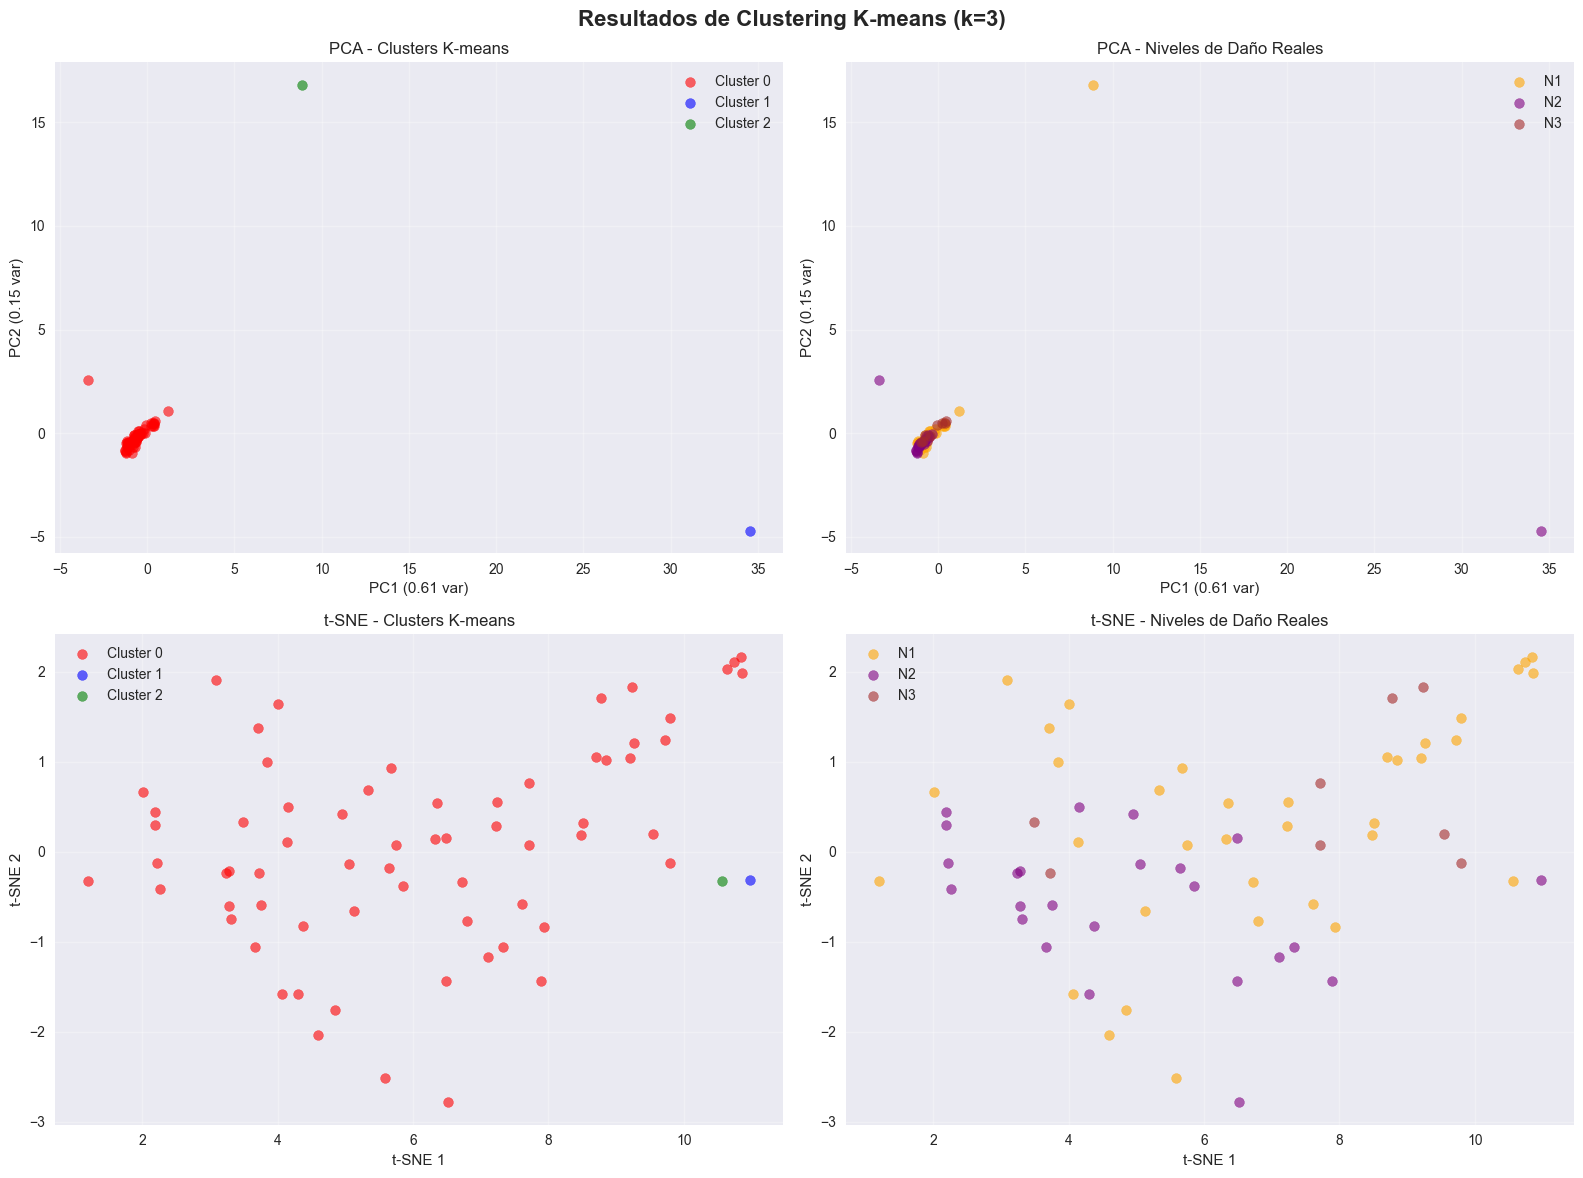

In [16]:
# Visualización de clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Resultados de Clustering K-means (k=3)', fontsize=16, fontweight='bold')

# Colores para clusters y niveles de daño
cluster_colors = ['red', 'blue', 'green']
damage_colors = ['orange', 'purple', 'brown']

# PCA - Clusters
for i in range(3):
    mask = cluster_labels == i
    axes[0,0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=cluster_colors[i], label=f'Cluster {i}', alpha=0.6, s=50)
axes[0,0].set_title('PCA - Clusters K-means')
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# PCA - Niveles de daño reales
damage_levels = [0, 1, 2]
damage_names = ['N1', 'N2', 'N3']
for i, (level, name) in enumerate(zip(damage_levels, damage_names)):
    mask = true_labels == level
    axes[0,1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=damage_colors[i], label=name, alpha=0.6, s=50)
axes[0,1].set_title('PCA - Niveles de Daño Reales')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f} var)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f} var)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# t-SNE - Clusters
for i in range(3):
    mask = cluster_labels_tsne == i
    axes[1,0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                      c=cluster_colors[i], label=f'Cluster {i}', alpha=0.6, s=50)
axes[1,0].set_title('t-SNE - Clusters K-means')
axes[1,0].set_xlabel('t-SNE 1')
axes[1,0].set_ylabel('t-SNE 2')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# t-SNE - Niveles de daño reales
for i, (level, name) in enumerate(zip(damage_levels, damage_names)):
    mask = true_labels_tsne == level
    axes[1,1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                      c=damage_colors[i], label=name, alpha=0.6, s=50)
axes[1,1].set_title('t-SNE - Niveles de Daño Reales')
axes[1,1].set_xlabel('t-SNE 1')
axes[1,1].set_ylabel('t-SNE 2')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Evaluación de Diferentes Valores de K

Evaluamos el clustering con diferentes valores de k para encontrar el número óptimo de clusters.

In [17]:
# Evaluación del número óptimo de clusters
print("🔄 Evaluando diferentes valores de k...")

k_range = range(2, 8)
inertias = []
silhouette_scores = []
ari_scores = []

for k in k_range:
    # Aplicar K-means
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels_k = kmeans_k.fit_predict(X_scaled)
    
    # Calcular métricas
    inertias.append(kmeans_k.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels_k))
    
    # ARI solo tiene sentido comparar con k=3 (número de niveles de daño)
    if k == 3:
        ari_scores.append(adjusted_rand_score(true_labels, cluster_labels_k))
    else:
        ari_scores.append(np.nan)
    
    print(f"  k={k}: Inercia={kmeans_k.inertia_:.2f}, Silhouette={silhouette_score(X_scaled, cluster_labels_k):.3f}")

print("✓ Evaluación completada")

🔄 Evaluando diferentes valores de k...
  k=2: Inercia=939.68, Silhouette=0.886
  k=3: Inercia=557.12, Silhouette=0.822
  k=4: Inercia=401.60, Silhouette=0.752
  k=5: Inercia=262.27, Silhouette=0.749
  k=6: Inercia=139.23, Silhouette=0.446
  k=7: Inercia=92.76, Silhouette=0.338
✓ Evaluación completada


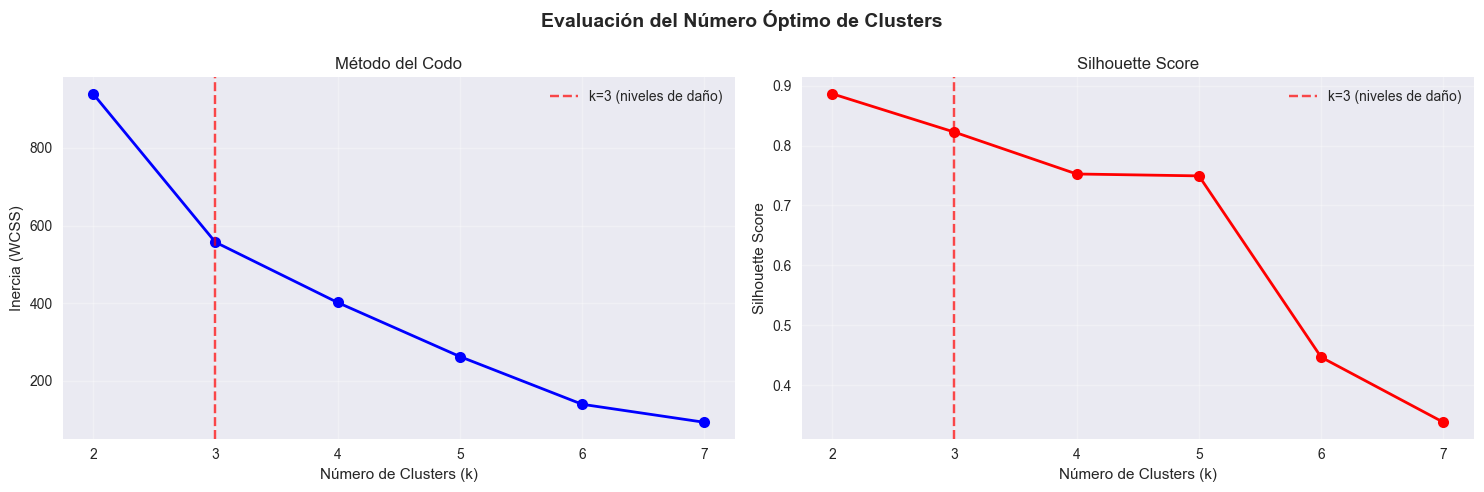


🎯 Número óptimo de clusters según Silhouette Score: k=2
   Silhouette Score máximo: 0.886

📊 Para k=3 (niveles de daño):
   Silhouette Score: 0.822
   Adjusted Rand Index: -0.005


In [18]:
# Visualizar métricas de evaluación
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Evaluación del Número Óptimo de Clusters', fontsize=14, fontweight='bold')

# Método del codo (Elbow Method)
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Método del Codo')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inercia (WCSS)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Marcar k=3
axes[0].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (niveles de daño)')
axes[1].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3 (niveles de daño)')
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

# Encontrar k óptimo basado en silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Número óptimo de clusters según Silhouette Score: k={optimal_k}")
print(f"   Silhouette Score máximo: {max(silhouette_scores):.3f}")
print(f"\n📊 Para k=3 (niveles de daño):")
print(f"   Silhouette Score: {silhouette_scores[1]:.3f}")
print(f"   Adjusted Rand Index: {ari_scores[1]:.3f}")

## 8. Conclusiones

Resumen de los hallazgos del análisis de clustering.

In [19]:
# Resumen de resultados
print("="*80)
print("🎯 CONCLUSIONES DEL ANÁLISIS DE CLUSTERING")
print("="*80)

print(f"\n📊 DATASET:")
print(f"   • Total especímenes: {raw_dataset['ID'].nunique()}")
print(f"   • Total observaciones: {len(features_df):,}")
print(f"   • Características extraídas: {len(feature_cols)}")
print(f"   • Niveles de daño: {sorted(raw_dataset['nivel_damage'].unique())}")

print(f"\n🔍 CLUSTERING K-MEANS (k=3):")
print(f"   • Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"   • Adjusted Rand Index: {ari_score:.3f}")
print(f"   • Inercia: {kmeans.inertia_:.2f}")

print(f"\n📈 SEPARABILIDAD:")
if ari_score > 0.5:
    separability = "BUENA"
elif ari_score > 0.2:
    separability = "MODERADA"
else:
    separability = "LIMITADA"

print(f"   • Separabilidad entre niveles de daño: {separability}")
print(f"   • Los clusters {'SÍ' if ari_score > 0.3 else 'NO'} corresponden bien con los niveles de daño")

print(f"\n🎯 NÚMERO ÓPTIMO DE CLUSTERS:")
print(f"   • Según Silhouette Score: k={optimal_k}")
print(f"   • Para aplicaciones de diagnóstico: k=3 (correspondiente a niveles de daño)")

print(f"\n💡 RECOMENDACIONES:")
print(f"   • Los datos raw {'muestran' if ari_score > 0.2 else 'NO muestran'} separación clara entre niveles de daño")
print(f"   • Se recomienda {'continuar' if ari_score > 0.2 else 'explorar otras técnicas de'} con análisis de clustering")
if ari_score <= 0.2:
    print(f"   • Considerar preprocesamiento adicional o extracción de características avanzadas")
    print(f"   • Explorar algoritmos de clustering no lineales (DBSCAN, clustering jerárquico)")

print("\n" + "="*80)

# Guardar resultados
results_summary = {
    'dataset_size': len(features_df),
    'n_specimens': raw_dataset['ID'].nunique(),
    'n_features': len(feature_cols),
    'silhouette_score': silhouette_score(X_scaled, cluster_labels),
    'ari_score': ari_score,
    'optimal_k': optimal_k,
    'separability': separability
}

print(f"\n💾 Resultados guardados en memoria para análisis posteriores")

🎯 CONCLUSIONES DEL ANÁLISIS DE CLUSTERING

📊 DATASET:
   • Total especímenes: 34
   • Total observaciones: 68
   • Características extraídas: 32
   • Niveles de daño: ['N1', 'N2', 'N3']

🔍 CLUSTERING K-MEANS (k=3):
   • Silhouette Score: 0.822
   • Adjusted Rand Index: -0.005
   • Inercia: 557.12

📈 SEPARABILIDAD:
   • Separabilidad entre niveles de daño: LIMITADA
   • Los clusters NO corresponden bien con los niveles de daño

🎯 NÚMERO ÓPTIMO DE CLUSTERS:
   • Según Silhouette Score: k=2
   • Para aplicaciones de diagnóstico: k=3 (correspondiente a niveles de daño)

💡 RECOMENDACIONES:
   • Los datos raw NO muestran separación clara entre niveles de daño
   • Se recomienda explorar otras técnicas de con análisis de clustering
   • Considerar preprocesamiento adicional o extracción de características avanzadas
   • Explorar algoritmos de clustering no lineales (DBSCAN, clustering jerárquico)


💾 Resultados guardados en memoria para análisis posteriores
